<a href="https://colab.research.google.com/github/LeeYuuuan/ECGR-5106-HW1/blob/main/housing_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
housing_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Real Time ML/Housing.csv")
housing_data.dropna(inplace=True)
housing_data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [ ]:
num_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
std_features = ['area']
cat_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                'airconditioning', 'prefarea', 'furnishingstatus']

num_scaler = StandardScaler()
housing_data[std_features] = num_scaler.fit_transform(housing_data[std_features])

df_X = housing_data[num_features + cat_features]

scaler_y = StandardScaler()
df_y = housing_data["price"]
y = df_y.values.reshape(-1, 1)
y = scaler_y.fit_transform(y)
tensor_y = torch.tensor(y, dtype=torch.float32)

In [ ]:
df_X

,area,bedrooms,bathrooms,stories,parking,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
0,1.046726,4,2,3,2,yes,no,no,no,yes,yes,furnished
1,1.757010,4,4,4,3,yes,no,no,no,yes,no,furnished
2,2.218232,3,2,2,2,yes,no,yes,no,no,yes,semi-furnished
3,1.083624,4,2,2,3,yes,no,yes,no,yes,yes,furnished
4,1.046726,4,1,2,2,yes,yes,yes,no,yes,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...
540,-0.991879,2,1,1,2,yes,no,yes,no,no,no,unfurnished
541,-1.268613,3,1,1,0,no,no,no,no,no,no,semi-furnished
542,-0.705921,2,1,1,0,yes,no,no,no,no,no,unfurnished
543,-1.033389,3,1,1,0,no,no,no,no,no,no,furnished


## problem 2a data preprocessing

In [ ]:
df_X_2a = df_X.copy()

label_encoder = LabelEncoder()
for col in cat_features:
    le = LabelEncoder()
    df_X_2a[col] = le.fit_transform(df_X_2a[col])

df_X_2a = df_X_2a[num_features + cat_features]

tensor_X = torch.tensor(df_X_2a.values, dtype=torch.float32)

X_train_2a, X_test_2a, y_train_2a, y_test_2a = train_test_split(tensor_X, tensor_y, test_size=0.2, random_state=42)



In [ ]:
X_train_2a.shape

torch.Size([436, 12])

## problem 2b data preprocessing

In [ ]:
df_X_2b = df_X.copy()

# one-hot encoding
one_hot = OneHotEncoder(sparse_output=False)

one_hot_o = OneHotEncoder(sparse_output=False, drop='first')

cat_encoded = one_hot.fit_transform(df_X_2b[cat_features])
cat_columns = one_hot.get_feature_names_out(cat_features)
cat_df = pd.DataFrame(cat_encoded, columns=cat_columns)

# concatenate the one-hot encoded columns with the numerical features
df_X_2b = pd.concat([df_X_2b[num_features], cat_df], axis=1)

tensor_X_2b = torch.tensor(df_X_2b.values, dtype=torch.float32)

X_train_2b, X_test_2b, y_train_2b, y_test_2b = train_test_split(tensor_X_2b, tensor_y, test_size=0.2, random_state=42)


In [ ]:
X_train_2b.shape

torch.Size([436, 20])

In [ ]:
class MLPRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim=[32, 32], output_dim=1):
        super(MLPRegression, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim[0])


        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dim) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))

        self.output_layer = nn.Linear(hidden_dim[-1], output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x


## problem 2a & 2b

In [ ]:
class HousingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], output_dim=1):
        super(HousingMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            # layers.append(nn.Dropout(0.1))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, learning_rate=0.001):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses, val_losses = [], []
    r2_list = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        total_samples = 0

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        preds_list = []
        labels_list = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds_list.append(outputs.cpu().numpy())
                labels_list.append(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Calculate R2
        total_preds = np.concatenate(preds_list, axis=0).squeeze()
        total_labels = np.concatenate(labels_list, axis=0).squeeze()
        r2 = r2_score(total_labels, total_preds)
        r2_list.append(r2)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2: {r2:.4f}")

    return train_losses, val_losses, r2_list


In [ ]:
learning_rate = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"
model_2a = MLPRegression(input_dim=X_train_2a.shape[1]).to(device)
model_2b = MLPRegression(input_dim=X_train_2b.shape[1]).to(device)


In [ ]:
def plot_results(train_loss, train_loss_with_one_hot, test_loss, test_loss_with_one_hot, r2, r2_with_one_hot):

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(train_loss_with_one_hot, label='Training Loss with One-Hot Encoding')
    plt.plot(test_loss, label='Test Loss')
    plt.plot(test_loss_with_one_hot, label='Test Loss with One-Hot Encoding')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(r2, label='R2 Score')
    plt.plot(r2_with_one_hot, label='R2 Score with One-Hot Encoding')
    plt.xlabel('Epoch')
    plt.ylabel('R2 Score')
    plt.title('R2 Score vs Epoch')
    plt.legend()
    plt.show()


In [ ]:
train_losses_2a, val_losses_2a, r2_list_2a = train_model(model_2a, X_train_2a, y_train_2a, X_test_2a, y_test_2a)
train_losses_2b, val_losses_2b, r2_list_2b = train_model(model_2b, X_train_2b, y_train_2b, X_test_2b, y_test_2b)

Epoch 1/100, Train Loss: 0.8751, Val Loss: 1.4361, R2: 0.0240
Epoch 2/100, Train Loss: 0.8028, Val Loss: 1.3258, R2: 0.0951
Epoch 3/100, Train Loss: 0.7488, Val Loss: 1.2490, R2: 0.1474
Epoch 4/100, Train Loss: 0.7037, Val Loss: 1.1777, R2: 0.1974
Epoch 5/100, Train Loss: 0.6548, Val Loss: 1.0960, R2: 0.2547
Epoch 6/100, Train Loss: 0.6001, Val Loss: 1.0042, R2: 0.3187
Epoch 7/100, Train Loss: 0.5358, Val Loss: 0.9141, R2: 0.3827
Epoch 8/100, Train Loss: 0.4753, Val Loss: 0.8254, R2: 0.4457
Epoch 9/100, Train Loss: 0.4301, Val Loss: 0.7443, R2: 0.5031
Epoch 10/100, Train Loss: 0.3887, Val Loss: 0.6894, R2: 0.5430
Epoch 11/100, Train Loss: 0.3686, Val Loss: 0.6498, R2: 0.5711
Epoch 12/100, Train Loss: 0.3558, Val Loss: 0.6414, R2: 0.5790
Epoch 13/100, Train Loss: 0.3457, Val Loss: 0.6180, R2: 0.5941
Epoch 14/100, Train Loss: 0.3401, Val Loss: 0.6160, R2: 0.5961
Epoch 15/100, Train Loss: 0.3336, Val Loss: 0.6099, R2: 0.5998
Epoch 16/100, Train Loss: 0.3295, Val Loss: 0.6058, R2: 0.6028
E

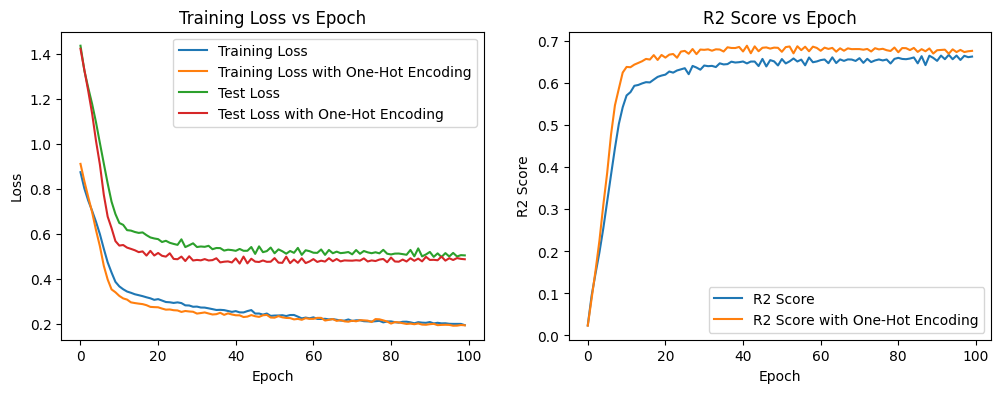

In [ ]:
plot_results(train_losses_2a, train_losses_2b, val_losses_2a, val_losses_2b, r2_list_2a, r2_list_2b)

## futher increase the model complexity and get more detial results

In [ ]:
def plot_loss(train_losses, test_losses):
    len_los = len(train_losses)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(len_los):
        plt.plot(range(1, num_epochs+1), train_losses[i], label=f'Training Loss {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('training Loss')
    plt.legend()

    plt.title('training Loss vs Epoch')
    plt.subplot(1, 2, 2)
    for i in range(len_los):
        plt.plot(range(1, num_epochs+1), test_losses[i], label=f'Test Loss {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.legend()
    plt.title('Test Loss vs Epoch')
    plt.show()


In [ ]:
model_2b_complex_1 = MLPRegression(input_dim=X_train_2b.shape[1], hidden_dim=[128, 128, 128, 64]).to(device)
model_2b_complex_2 = MLPRegression(input_dim=X_train_2b.shape[1], hidden_dim=[128, 128, 128, 128, 64]).to(device)
model_2b_complex_3 = MLPRegression(input_dim=X_train_2b.shape[1], hidden_dim=[128, 128, 128, 128, 128, 64]).to(device)
model_2b_complex_4 = MLPRegression(input_dim=X_train_2b.shape[1], hidden_dim=[256, 256, 256, 256, 128, 64]).to(device)
model_2b_complex_5 = MLPRegression(input_dim=X_train_2b.shape[1], hidden_dim=[256, 256, 256, 256, 256, 128, 64]).to(device)

In [ ]:
def get_multi_results(model_list=[model_2b, model_2b_complex_1, model_2b_complex_2, model_2b_complex_3, model_2b_complex_4, model_2b_complex_5]):

    train_losses = []

    test_losses = []
    test_losses.append(val_losses_2b)
    r2_list = []

    for model in model_list:
        train_loss, test_loss, r2 = train_model(model, X_train_2b, y_train_2b, X_test_2b, y_test_2b, epochs=100, batch_size=64, learning_rate=0.001)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        r2_list.append(r2)

    plot_loss(train_losses, test_losses)

Epoch 1/100, Train Loss: 0.2040, Val Loss: 0.4805, R2: 0.6817
Epoch 2/100, Train Loss: 0.1944, Val Loss: 0.4970, R2: 0.6726
Epoch 3/100, Train Loss: 0.1919, Val Loss: 0.4956, R2: 0.6727
Epoch 4/100, Train Loss: 0.1908, Val Loss: 0.4986, R2: 0.6712
Epoch 5/100, Train Loss: 0.1901, Val Loss: 0.4936, R2: 0.6742
Epoch 6/100, Train Loss: 0.1913, Val Loss: 0.4884, R2: 0.6769
Epoch 7/100, Train Loss: 0.1886, Val Loss: 0.5034, R2: 0.6679
Epoch 8/100, Train Loss: 0.1896, Val Loss: 0.4823, R2: 0.6808
Epoch 9/100, Train Loss: 0.1904, Val Loss: 0.4983, R2: 0.6716
Epoch 10/100, Train Loss: 0.1886, Val Loss: 0.4964, R2: 0.6725
Epoch 11/100, Train Loss: 0.1888, Val Loss: 0.5068, R2: 0.6656
Epoch 12/100, Train Loss: 0.1887, Val Loss: 0.4945, R2: 0.6735
Epoch 13/100, Train Loss: 0.1874, Val Loss: 0.4994, R2: 0.6699
Epoch 14/100, Train Loss: 0.1892, Val Loss: 0.4953, R2: 0.6725
Epoch 15/100, Train Loss: 0.1886, Val Loss: 0.4982, R2: 0.6708
Epoch 16/100, Train Loss: 0.1845, Val Loss: 0.4897, R2: 0.6766
E

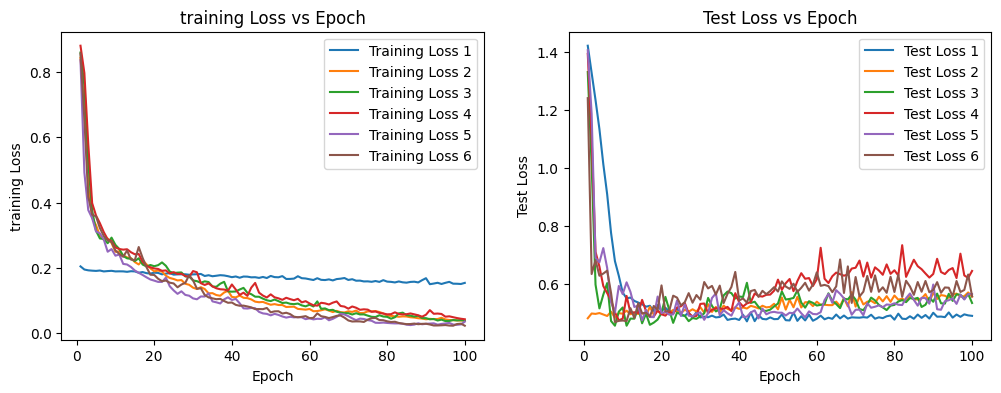

In [ ]:
get_multi_results()